# ML model generation

This notebook creates and trains a simple sine wave detection model by following the example provided at https://github.com/tensorflow/tflite-micro/blob/main/tensorflow/lite/micro/examples/hello_world/README.md. At the end, the model is exported as `model.bin`.

In [34]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
import struct

save_model = False

In [30]:
def get_data(seed=0):
    '''Generates data for the model'''
    np.random.seed(seed)
    x = np.random.uniform(low=0, high=2*np.pi, size=1000)
    np.random.shuffle(x)
    x = torch.from_numpy(x).view(-1,1).float()
    
    y = torch.sin(x)

    return x,y

In [31]:
class Model(nn.Module):
    def __init__(self, dim):
        super(Model, self).__init__()
        self.dim = dim
        self.layers = nn.ModuleList([nn.Linear(1, dim),
                                    nn.Linear(dim, dim)])
        self.activation = nn.ReLU()
        self.out = nn.Linear(dim, 1)
        
    def forward(self, x):
        for layer in self.layers:
            x = self.activation(layer(x))
        
        x = self.out(x)
        
        return x

0.814832329750061
0.0014847168931737542
0.00010984823165927082
7.605277642142028e-05
6.832901999587193e-05
6.063352702767588e-05
5.3533549362327904e-05
5.017977673560381e-05
4.854237340623513e-05
4.716053808806464e-05


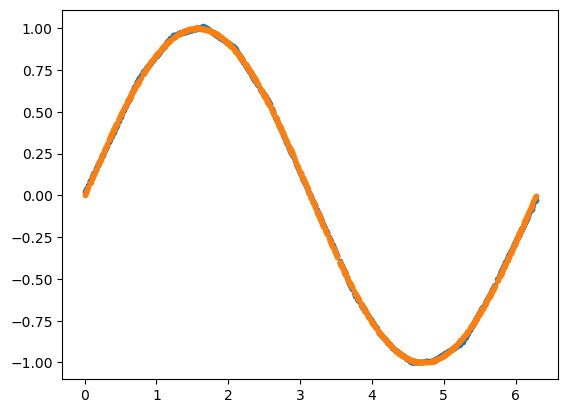

In [32]:
model = Model(16)
loss_fn = nn.MSELoss()
opt = torch.optim.AdamW(model.parameters(), lr=0.002)
x,y = get_data()

for epoch in range(10000):
    opt.zero_grad()
    out = model(x)
    loss = loss_fn(out, y)
    loss.backward()
    opt.step()
    if epoch%1000==0:
        print(loss.item())

xval, yval = get_data()
plt.plot(xval.numpy(), model(xval).detach().numpy(), ".")
plt.plot(xval.numpy(), yval.numpy(), ".")

In [33]:
def serialize_fp32(file, tensor):
    """ writes one fp32 tensor to file that is open in wb mode """
    d = tensor.detach().cpu().view(-1).to(torch.float32).numpy()
    b = struct.pack(f'{len(d)}f', *d)
    file.write(b)
 
    
if save_model:
    filepath = "model.bin"

    f = open(filepath, "wb")

    header = struct.pack("i", model.dim)
    f.write(header)
    pad = 256 - f.tell() # pad rest with zeros
    assert pad >= 0
    f.write(b'\0'*pad)
    
    weights = [*[layer.weight for layer in model.layers], model.out.weight]
    bias = [*[layer.bias for layer in model.layers], model.out.bias]
    for w in weights:
        serialize_fp32(f, w)
    
    for b in bias:
        serialize_fp32(f, w)

    f.close()